<a href="https://colab.research.google.com/github/kurasaiteja/Whatsapp-Analysis/blob/master/Whatsapp_Group_Chat_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whatsapp Group Chat Data Analysis using python.

Hey there! This a project which would keep evolving with time.

A typical data science project would involve 5 steps. The first step is Data Collection. In this case Data collection involves

Opening Whatsapp group chat.
Go to Settings.
Click on Export Chat.
Click on without media.

In [1]:
!pip install emoji

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=e1439838ad5c59bdf00bf70acf78091f0525f515bb8fd0a1cf1bd038d484be9d
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [2]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [3]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 5773 (delta 33), reused 46 (delta 3), pack-reused 5667
Receiving objects: 100% (5773/5773), 105.93 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (3368/3368), done.
/content/word_cloud
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post88+ge196d19-cp36-cp36m-linux_x86_64.whl size=338626 sha256=db813b0807b2593a9d9dc87d14b4b5d510809d765dd4d0923bc0063ba37c998e
  Stored in directory: /tmp/pip-ephem-wheel-cache-go_mtfan/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}






In [4]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (AM|PM) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [5]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [6]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message


In [7]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/WhatsApp Chat with Blabla (1).txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [8]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])

In [9]:
df.head()

,Date,Time,Author,Message
0,2019-03-07,6:45 PM,None,"Aakarsh Yelisetty created group ""Blabla"""
1,2019-04-01,7:33 PM,None,Aakarsh Yelisetty added you
2,2019-04-01,7:40 PM,Manikanta,Hello hackers 👨🏻‍💻👨🏻‍💻
3,2019-04-01,7:43 PM,Manikanta,"Em ina pedthe, topper ga.. Hacker ga.. Racha l..."
4,2019-04-01,7:43 PM,Manikanta,Roll back


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35043 entries, 0 to 35042
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     35043 non-null  datetime64[ns]
 1   Time     35043 non-null  object        
 2   Author   35023 non-null  object        
 3   Message  35043 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.1+ MB


## Printing Participants

In [11]:
df.Author.unique()

array([None, 'Manikanta', 'Aakarsh Yelisetty', 'Vishal Gurrala',
       'Gowtham Bujjam', 'Teja Kura'], dtype=object)

**None** which is the first element in array indicates few messages which do not have authors like,


*   Group was created.
*   Teja was added and so on.



Let us remove the messages created by None

In [12]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35023 entries, 2 to 35042
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     35023 non-null  datetime64[ns]
 1   Time     35023 non-null  object        
 2   Author   35023 non-null  object        
 3   Message  35023 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.3+ MB


In [13]:
df.Author.unique()

array(['Manikanta', 'Aakarsh Yelisetty', 'Vishal Gurrala',
       'Gowtham Bujjam', 'Teja Kura'], dtype=object)

We successfully removed None author.

# Group Wise Stats.

In [14]:
total_messages = df.shape[0]
print(total_messages)

35023


Let us now find out the total Media Messages

In [15]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

2926


In [16]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)

In [17]:
emojis = sum(df['emoji'].str.len())
print(emojis)

6219


In [18]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [19]:
links = np.sum(df.urlcount)

In [20]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 35023
Media: 2926
Emojis: 6219
Links: 243


## Let us Separate the media messages and text messages

In [21]:
media_messages_df = df[df['Message'] == '<Media omitted>']

In [22]:
messages_df = df.drop(media_messages_df.index)

In [43]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32097 entries, 2 to 35042
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          32097 non-null  datetime64[ns]
 1   Time          32097 non-null  object        
 2   Author        32097 non-null  object        
 3   Message       32097 non-null  object        
 4   emoji         32097 non-null  object        
 5   urlcount      32097 non-null  int64         
 6   Letter_Count  32097 non-null  int64         
 7   Word_Count    32097 non-null  int64         
 8   MessageCount  32097 non-null  int64         
 9   emojicount    32097 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 2.7+ MB


It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [23]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [24]:
messages_df.head()

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
2,2019-04-01,7:40 PM,Manikanta,Hello hackers 👨🏻‍💻👨🏻‍💻,"[👨🏻‍💻, 👨🏻‍💻]",0,22,3,1
3,2019-04-01,7:43 PM,Manikanta,"Em ina pedthe, topper ga.. Hacker ga.. Racha l...",[],0,72,12,1
4,2019-04-01,7:43 PM,Manikanta,Roll back,[],0,9,2,1
5,2019-04-01,7:43 PM,Manikanta,Ventane anni delete chesi dengude,[],0,33,5,1
6,2019-04-01,7:43 PM,Aakarsh Yelisetty,😂,[😂],0,1,1,1


In [25]:
messages_df["emojicount"]= df['emoji'].str.len()

#Author wise stats

In [26]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Manikanta -
Messages Sent 5237
Words per message 4.250525109795684
Media Messages Sent 392
Emojis Sent 1107
Links Sent 46

Stats of Aakarsh Yelisetty -
Messages Sent 5100
Words per message 3.804705882352941
Media Messages Sent 592
Emojis Sent 1293
Links Sent 79

Stats of Vishal Gurrala -
Messages Sent 8982
Words per message 3.3736361612113117
Media Messages Sent 502
Emojis Sent 1306
Links Sent 54

Stats of Gowtham Bujjam -
Messages Sent 5578
Words per message 2.837217640731445
Media Messages Sent 743
Emojis Sent 1744
Links Sent 15

Stats of Teja Kura -
Messages Sent 7200
Words per message 3.9588888888888887
Media Messages Sent 697
Emojis Sent 769
Links Sent 49



# Most used Emoji in Group

# Emoji Stats

### Unique emojis used in group

In [27]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

185


### Most used emoji

In [28]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 2522), ('🤣', 1326), ('\U0001f97a', 369), ('😒', 208), ('🔥', 74), ('🙄', 72), ('😞', 63), ('🤦🏻\u200d♂', 58), ('\U0001f973', 54), ('🤙🏻', 46), ('🤕', 44), ('😪', 44), ('😭', 42), ('🙂', 42), ('🤧', 40), ('😢', 40), ('😮', 39), ('😅', 35), ('🤦🏻\u200d♂️', 35), ('😨', 32), ('😔', 32), ('😏', 31), ('🙃', 30), ('😕', 30), ('😎', 29), ('\U0001f975', 27), ('😱', 26), ('🤥', 24), ('🤢', 23), ('💥', 22), ('🙏', 21), ('😁', 19), ('😆', 19), ('👏🏻', 18), ('\U0001f928', 18), ('😖', 18), ('\U0001f92f', 18), ('😑', 17), ('😣', 17), ('🙏🏻', 17), ('👍🏻', 16), ('☹️', 16), ('😟', 15), ('😳', 15), ('🤷🏻\u200d♂', 14), ('🍃', 13), ('\U0001f974', 13), ('😲', 12), ('\U0001f929', 11), ('\U0001f971', 11), ('🕺🏻', 10), ('😍', 10), ('😓', 10), ('😤', 9), ('😐', 9), ('\U0001f970', 9), ('😴', 9), ('🤷🏻\u200d♂️', 9), ('🤔', 8), ('🤐', 8), ('\U0001f92e', 8), ('👍', 8), ('🍻', 8), ('\U0001f9d0', 8), ('😦', 8), ('😶', 7), ('👀', 7), ('😬', 7), ('😡', 7), ('👗', 7), ('🙁', 7), ('💯', 7), ('🙆🏻\u200d♂', 6), ('\U0001f92d', 6), ('😹', 6), ('😇', 6), ('\U0001f9b8\u200d♂️', 6

In [29]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,2522
1,🤣,1326
2,🥺,369
3,😒,208
4,🔥,74
...,...,...
180,😥,1
181,👋,1
182,😗,1
183,🍀,1


We can see '😂 '   dominates the list.

### Emoji distribution visualisation

In [30]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [31]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Manikanta


Emoji Distribution for Aakarsh Yelisetty


Emoji Distribution for Vishal Gurrala


Emoji Distribution for Gowtham Bujjam


Emoji Distribution for Teja Kura


# Some more Stats

### **Day wise Distribution**

In [32]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [33]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,6000]
    )),
  showlegend=False
)
fig.show()

### **Number of messages as times move on**

In [48]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

### **Chatter**

In [35]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

### **When are the group members most active?**

Text(0, 0.5, 'Time')

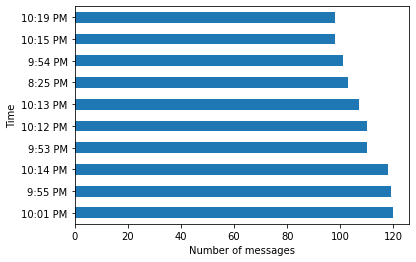

In [36]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

### **The most happening day was -**

2019-07-26    720
2020-06-26    469
2020-04-06    436
2019-08-18    433
2019-08-12    409
             ... 
2019-04-28      1
2019-10-17      1
2019-09-24      1
2020-01-29      1
2019-04-15      1
Name: Date, Length: 377, dtype: int64


Text(0, 0.5, 'Date')

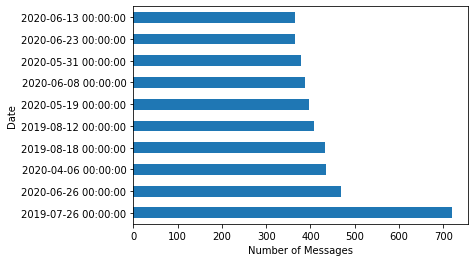

In [37]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### **The early bird**

### The Late Owl

### **Message Having Maximum number of words**

In [38]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2020-03-19 00:00:00
Time                                                     11:02 AM
Author                                          Aakarsh Yelisetty
Message         *Since, you are working from home, forwarding ...
emoji                                                          []
urlcount                                                       30
Letter_Count                                                 4907
Word_Count                                                    592
MessageCount                                                    1
emojicount                                                      0
Name: 17225, dtype: object

Interestingly the Same message has the highest number of URL's and 0 emojis.

### **Word Cloud**

In [39]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 687467 words in all the messages.


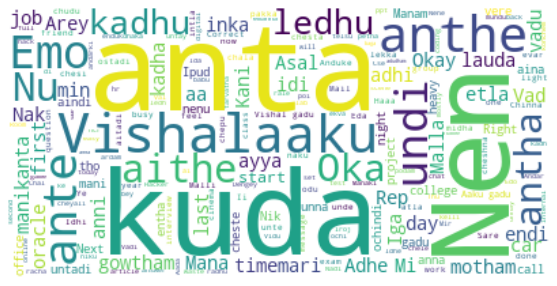

In [46]:
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

Author name Manikanta


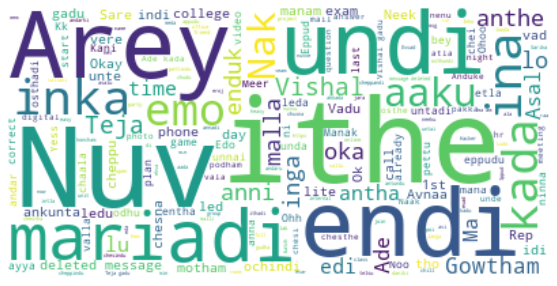

Author name Aakarsh Yelisetty


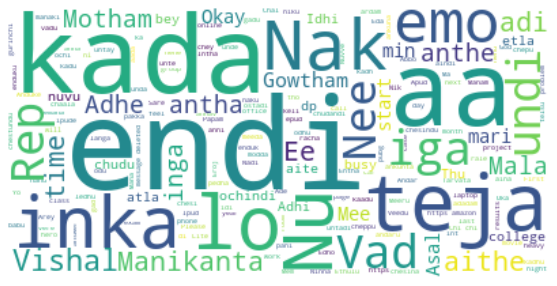

Author name Vishal Gurrala


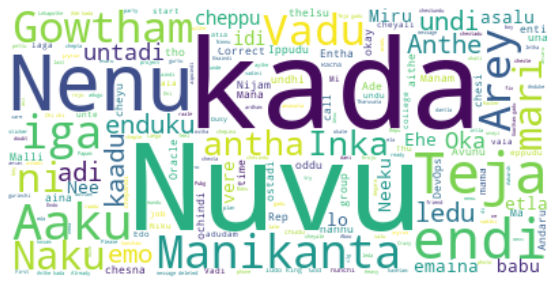

Author name Gowtham Bujjam


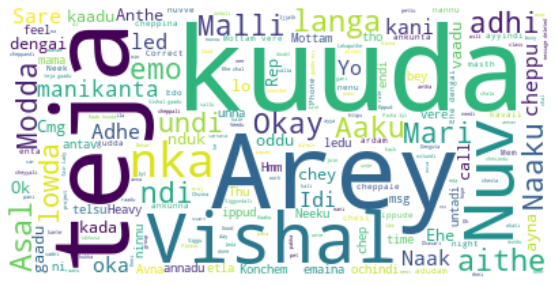

Author name Teja Kura


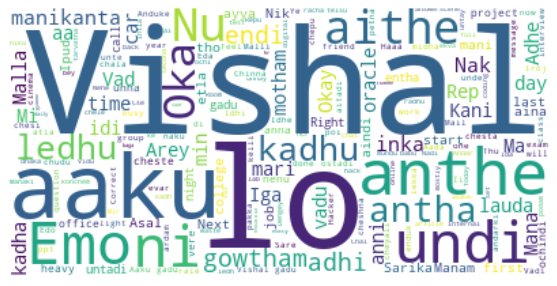

In [41]:
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
  # Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [42]:
""

''